# 3.simpleImplOfLinearReg
在过去的几年里，出于对深度学习强烈的兴趣， 许多公司、学者和业余爱好者开发了各种成熟的开源框架。 这些框架可以自动化基于梯度的学习算法中重复性的工作。 在 3.2节中，我们只运用了： （1）通过张量来进行数据存储和线性代数； （2）通过自动微分来计算梯度。 实际上，由于数据迭代器、损失函数、优化器和神经网络层很常用， 现代深度学习库也为我们实现了这些组件。

## 1.生成数据集


In [1]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w=torch.tensor([2,-3.4])
true_b=4.2
features,labels=d2l.synthetic_data(true_w,true_b,1000)
print(features,'\n',labels)

tensor([[ 0.6700,  0.9599],
        [-0.3684, -2.0129],
        [-0.2929, -0.6725],
        ...,
        [-0.3707,  0.2497],
        [ 0.9665,  0.4493],
        [-0.1205, -0.4608]]) 
 tensor([[ 2.2938e+00],
        [ 1.0299e+01],
        [ 5.8852e+00],
        [ 3.9700e+00],
        [ 5.7507e+00],
        [ 3.6166e+00],
        [ 6.2004e+00],
        [ 8.1801e+00],
        [ 3.4512e+00],
        [ 1.4047e+00],
        [-1.2953e-01],
        [-1.1409e+00],
        [ 5.2207e+00],
        [ 5.8871e+00],
        [ 2.9749e+00],
        [ 6.7628e+00],
        [ 2.8177e+00],
        [ 4.7275e+00],
        [ 5.6559e+00],
        [ 1.2198e+00],
        [ 5.4185e+00],
        [ 3.6422e+00],
        [ 8.6297e+00],
        [ 2.3903e+00],
        [ 6.9266e+00],
        [ 1.2098e+00],
        [ 4.1138e+00],
        [ 7.2147e+00],
        [ 7.7027e+00],
        [ 3.9174e+00],
        [ 4.7617e+00],
        [-9.9500e-01],
        [ 9.0535e+00],
        [-4.5744e+00],
        [ 1.0415e+00],
        [ 3

## 2.读取数据集
我们可以调用框架中现有的API来读取数据。 我们将features和labels作为API的参数传递，并通过数据迭代器指定batch_size。 此外，布尔值is_train表示是否希望数据迭代器对象在每个迭代周期内打乱数据。

使用data_iter的方式与我们在 3.2节中使用data_iter函数的方式相同。为了验证是否正常工作，让我们读取并打印第一个小批量样本。 与 3.2节不同，这里我们使用iter构造Python迭代器，并使用next从迭代器中获取第一项。

In [2]:
def load_array(data_arrays,batch_size,is_train=True):#@save
    """构造一个Pytorch数据解析器"""
    dataset=data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset,batch_size,shuffle=is_train)
batch_size=10
data_tier=load_array((features,labels),batch_size)
next(iter(data_tier))

[tensor([[ 0.3935,  1.4295],
         [ 0.2042, -0.5667],
         [-0.5833, -1.0499],
         [ 0.8844,  0.8466],
         [ 2.0272, -1.4616],
         [ 0.0306, -0.4905],
         [-0.2679, -1.3255],
         [-0.1542,  0.8473],
         [ 0.4116,  1.1982],
         [-0.7376, -0.2153]]),
 tensor([[ 0.1336],
         [ 6.5411],
         [ 6.6068],
         [ 3.0862],
         [13.2114],
         [ 5.9379],
         [ 8.1798],
         [ 1.0014],
         [ 0.9432],
         [ 3.4431]])]

## 3.定义模型
当我们在 3.2节中实现线性回归时， 我们明确定义了模型参数变量，并编写了计算的代码，这样通过基本的线性代数运算得到输出。 但是，如果模型变得更加复杂，且当我们几乎每天都需要实现模型时，自然会想简化这个过程。 这种情况类似于为自己的博客从零开始编写网页。 做一两次是有益的，但如果每个新博客就需要工程师花一个月的时间重新开始编写网页，那并不高效。

对于标准深度学习模型，我们可以使用框架的预定义好的层。这使我们只需关注使用哪些层来构造模型，而不必关注层的实现细节。 我们首先定义一个模型变量net，它是一个Sequential类的实例。 Sequential类将多个层串联在一起。 当给定输入数据时，Sequential实例将数据传入到第一层， 然后将第一层的输出作为第二层的输入，以此类推。 在下面的例子中，我们的模型只包含一个层，因此实际上不需要Sequential。 但是由于以后几乎所有的模型都是多层的，在这里使用Sequential会让你熟悉“标准的流水线”。

回顾 图3.1.2中的单层网络架构， 这一单层被称为全连接层（fully-connected layer）， 因为它的每一个输入都通过矩阵-向量乘法得到它的每个输出。

在PyTorch中，全连接层在Linear类中定义。 值得注意的是，我们将两个参数传递到nn.Linear中。 第一个指定输入特征形状，即2，第二个指定输出特征形状，输出特征形状为单个标量，因此为1。

In [3]:
# nn是神经网络缩写
from torch import nn
#指定输入维度2，输出维度1
net=nn.Sequential(nn.Linear(2,1))

## 4.初始化模型参数
在使用net之前，我们需要初始化模型参数。 如在线性回归模型中的权重和偏置。 深度学习框架通常有预定义的方法来初始化参数。 在这里，我们指定每个权重参数应该从均值为0、标准差为0.01的正态分布中随机采样， 偏置参数将初始化为零。
正如我们在构造nn.Linear时指定输入和输出尺寸一样， 现在我们能直接访问参数以设定它们的初始值。 我们通过net[0]选择网络中的第一个图层， 然后使用weight.data和bias.data方法访问参数。 我们还可以使用替换方法normal_和fill_来重写参数值。


In [4]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

## 5.定义损失函数
    计算均方误差使用的是MSELoss类，也称为平方L2范数。 默认情况下，它返回所有样本损失的平均值。

In [5]:
loss = nn.MSELoss()

## 6.定义优化算法
小批量随机梯度下降算法是一种优化神经网络的标准工具， PyTorch在optim模块中实现了该算法的许多变种。 当我们实例化一个SGD实例时，我们要指定优化的参数 （可通过net.parameters()从我们的模型中获得）以及优化算法所需的超参数字典。 小批量随机梯度下降只需要设置lr值，这里设置为0.03。

In [6]:
trainer=torch.optim.SGD(net.parameters(),lr=0.1)

## 7.训练
通过深度学习框架的高级API来实现我们的模型只需要相对较少的代码。 我们不必单独分配参数、不必定义我们的损失函数，也不必手动实现小批量随机梯度下降。 当我们需要更复杂的模型时，高级API的优势将大大增加。 当我们有了所有的基本组件，训练过程代码与我们从零开始实现时所做的非常相似。

回顾一下：在每个迭代周期里，我们将完整遍历一次数据集（train_data）， 不停地从中获取一个小批量的输入和相应的标签。 对于每一个小批量，我们会进行以下步骤:

通过调用net(X)生成预测并计算损失l（前向传播）。

通过进行反向传播来计算梯度。

通过调用优化器来更新模型参数。

为了更好的衡量训练效果，我们计算每个迭代周期后的损失，并打印它来监控训练过程。

In [14]:
num_epochs=20
for epoch in range(num_epochs):
    for X,y in data_tier:
        l=loss(net(X),y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l=loss(net(features),labels)
    print(f'epoch{epoch+1},loss{l:f}')

epoch1,loss0.000121
epoch2,loss0.000124
epoch3,loss0.000134
epoch4,loss0.000104
epoch5,loss0.000101
epoch6,loss0.000108
epoch7,loss0.000113
epoch8,loss0.000103
epoch9,loss0.000126
epoch10,loss0.000125
epoch11,loss0.000115
epoch12,loss0.000121
epoch13,loss0.000103
epoch14,loss0.000129
epoch15,loss0.000102
epoch16,loss0.000105
epoch17,loss0.000105
epoch18,loss0.000102
epoch19,loss0.000107
epoch20,loss0.000104


下面我们比较生成数据集的真实参数和通过有限数据训练获得的模型参数。 要访问参数，我们首先从net访问所需的层，然后读取该层的权重和偏置。 正如在从零开始实现中一样，我们估计得到的参数与生成数据的真实参数非常接近。

In [13]:
w=net[0].weight.data
print('w的估计误差',true_w-w.reshape(true_w.shape))
b=net[0].bias.data
print('b的估计误差',true_b-b)

w的估计误差 tensor([0.0002, 0.0036])
b的估计误差 tensor([-0.0013])


# 9.练习


### 1.如果将小批量的总损失替换为小批量损失的平均值，需要如何更改学习率？

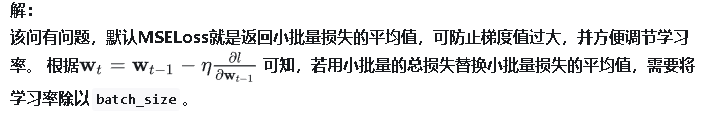

### 2.查看深度学习框架文档，它们提供了哪些损失函数和初始化方法？用Huber损失代替原损失，即
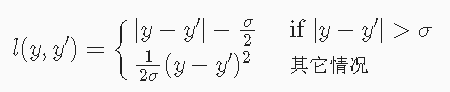

In [15]:
dir(nn)

['AdaptiveAvgPool1d',
 'AdaptiveAvgPool2d',
 'AdaptiveAvgPool3d',
 'AdaptiveLogSoftmaxWithLoss',
 'AdaptiveMaxPool1d',
 'AdaptiveMaxPool2d',
 'AdaptiveMaxPool3d',
 'AlphaDropout',
 'AvgPool1d',
 'AvgPool2d',
 'AvgPool3d',
 'BCELoss',
 'BCEWithLogitsLoss',
 'BatchNorm1d',
 'BatchNorm2d',
 'BatchNorm3d',
 'Bilinear',
 'Buffer',
 'CELU',
 'CTCLoss',
 'ChannelShuffle',
 'CircularPad1d',
 'CircularPad2d',
 'CircularPad3d',
 'ConstantPad1d',
 'ConstantPad2d',
 'ConstantPad3d',
 'Container',
 'Conv1d',
 'Conv2d',
 'Conv3d',
 'ConvTranspose1d',
 'ConvTranspose2d',
 'ConvTranspose3d',
 'CosineEmbeddingLoss',
 'CosineSimilarity',
 'CrossEntropyLoss',
 'CrossMapLRN2d',
 'DataParallel',
 'Dropout',
 'Dropout1d',
 'Dropout2d',
 'Dropout3d',
 'ELU',
 'Embedding',
 'EmbeddingBag',
 'FeatureAlphaDropout',
 'Flatten',
 'Fold',
 'FractionalMaxPool2d',
 'FractionalMaxPool3d',
 'GELU',
 'GLU',
 'GRU',
 'GRUCell',
 'GaussianNLLLoss',
 'GroupNorm',
 'Hardshrink',
 'Hardsigmoid',
 'Hardswish',
 'Hardtanh',
 

In [19]:
# loss=nn.SmoothL1Loss()
loss=torch.nn.HuberLoss(reduction='mean')
num_epochs=3
for epoch in range(num_epochs):
    for X,y in data_tier:
        l=loss(net(X),y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l=loss(net(features),labels)
    print(f'epoch{epoch+1},loss:{l:f}')
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

epoch1,loss:0.000053
epoch2,loss:0.000052
epoch3,loss:0.000052
w的估计误差： tensor([ 0.0003, -0.0021])
b的估计误差： tensor([0.0012])


优点
增强MSE的离群点鲁棒性 减小了对离群点的敏感度问题
误差较大时 使用MAE可降低异常值影响 使得训练更加健壮
Huber Loss下降速度介于MAE与MSE之间 弥补了MAE在Loss下降速度慢的问题 而更接近MSE

缺点
需要额外设置超参数

### 3.如何访问线性回归梯度

In [21]:
print(net[0].weight.grad,net[0].bias.grad)

tensor([[-0.0017, -0.0048]]) tensor([0.0032])
